In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio
import copy
from pprint import pprint
from pathlib import Path
from tqdm import tqdm, trange
sys.path.insert(1, '../')

from JPEG import JPEG
from libs.JPEGStandardHuffmanTable import STD_HUFTAB_LUMIN_DC, STD_HUFTAB_CHROMIN_DC, STD_HUFTAB_LUMIN_AC, STD_HUFTAB_CHROMIN_AC
from libs.util import psnr

from RDH import Scheme_Huang, Scheme_Extended

In [28]:
class JPEG_RDH():
    def __init__(self, image_path, quality, T, useGray=False):
        self.image_path = image_path
        self.jpeg = JPEG(image_path)
        self.jpeg.setHuffmanTable(isAC=False, index=0, table=STD_HUFTAB_LUMIN_DC())
        self.jpeg.setHuffmanTable(isAC=False, index=1, table=STD_HUFTAB_CHROMIN_DC())
        self.jpeg.setHuffmanTable(isAC=True, index=0, table=STD_HUFTAB_LUMIN_AC())
        self.jpeg.setHuffmanTable(isAC=True, index=1, table=STD_HUFTAB_CHROMIN_AC())
        self.jpeg.block_size = 8

        self.quality = self.jpeg.quality = quality
        self.T = T

    def generateOriginalImage(self, file_name=None, showImage=False):
        if file_name is None:
            file_name = '{}_Q{}'.format(Path(self.image_path).stem, self.quality)
        
        log = dict()
        jpeg_origin = copy.deepcopy(self.jpeg)
        jpeg_origin_image = jpeg_origin.encode(quality=self.quality, save_path=file_name, finished_info=log)
        if showImage:
            plt.imshow(jpeg_origin_image)
            plt.show()
            pprint(log)

        return file_name




    def prepare(self, quality=None, isColor=True):
        if quality is not None:
            self.quality = quality
        self.jpeg.ColorComp(isColor)
        self.jpeg._img2ycbcr(isColor=self.jpeg.ColorImage)
        self.jpeg._ycbcrDCT()
        self.jpeg._ycbcrQuant()
        self.Blocks = self.jpeg._ycbcrZigzag()

    def prepare_HuangScheme(self):
        self.locationMap = []
        self.free_size = 0

        for zblock_index in range(len(self.Blocks)):
            for comp_block_index in range(len(self.Blocks[zblock_index])):
                block = self.Blocks[zblock_index][comp_block_index]
                innerC = self.numberOfInnerCoefficients(block, -1)
                if (innerC > 0) and innerC < self.T:
                    self.locationMap.append((-1, zblock_index, comp_block_index))
                    self.free_size += innerC

    def prepare_ProposeScheme(self):
        ## Divide_Into_TwoSet
        self.locationMap = [] ## ([1: non-shifting, -1: shifting], zblock_index, comp_block_index)
        self.free_size = 0

        for zblock_index in range(len(self.Blocks)):
            for comp_block_index in range(len(self.Blocks[zblock_index])):
                block = self.Blocks[zblock_index][comp_block_index]
                shiftype = -1 if (np.any((block == -3) | (block == 3) | (block == 4) | (block == -4))) else 1
                innerC = self.numberOfInnerCoefficients(block, shiftype)
                if (innerC > 0) and (innerC < self.T):
                    self.locationMap.append((shiftype, zblock_index, comp_block_index))
                    self.free_size += innerC

    def embed_ProposeScheme(self, message):
        embedded_blocks = self.Embedding(message)
        new_jpeg = copy.deepcopy(self.jpeg)
        new_jpeg.zigzag = embedded_blocks
        new_jpeg._DPCMandRLE()
        new_jpeg.HuffmanTableBuilding(HuffmanTableTypeIndex=0)
        new_jpeg._HuffmanEncoding()
        new_jpeg._EntropyCodedStgment()
        save_path = "./4th/{}_DHS_Propose_Q{}_P{}".format(Path(self.image_path).stem, new_jpeg.quality, len(message))
        new_jpeg._writeToFile(save_path=save_path)
        return save_path

    def Embedding(self, message):
        m_index = 0
        new_blocks = np.copy(self.Blocks)
        self.message_length = len(message)
        for type, zblock_index, comp_index in self.locationMap:
            if type == 1:
                sch = Scheme_Extended(self.Blocks[zblock_index][comp_index])
            elif type == -1:
                sch = Scheme_Huang(self.Blocks[zblock_index][comp_index])
            sch.pre_Embedding()
            inner_AC = sch.freeSize()
            if (m_index+inner_AC > len(message)):
                new_m_index = len(message)
            else:
                new_m_index = m_index+inner_AC
            sch.embedding(message[m_index:new_m_index])
            m_index = new_m_index
            new_blocks[zblock_index][comp_index] = sch.block
            if new_m_index == len(message):
                break
        self.embedded_Blocks = new_blocks
        return self.embedded_Blocks

    def reStoring(self):
        new_blocks = np.copy(self.embedded_Blocks)
        message = []
        last_message_length = self.message_length
        n_i = 0
        for type, zblock_index, comp_index in self.locationMap:
            if type == 1:
                sch = Scheme_Extended(self.embedded_Blocks[zblock_index][comp_index])
            elif type == -1:
                sch = Scheme_Huang(self.embedded_Blocks[zblock_index][comp_index])
            reStored_block, m = sch.reStoring()
            new_blocks[zblock_index][comp_index] = reStored_block
            message.append("".join(str(i) for i in m))
            last_message_length -= len(message[-1])
            n_i += 1
            if last_message_length < 0:
                break
        return new_blocks, "".join(message)[:self.message_length]

    @classmethod
    def histogram(self, blocks):
        hist = []
        for zblock_index in range(len(blocks)):
            for comp_block_index in range(len(blocks[zblock_index])):
                rle = blocks[zblock_index][comp_block_index][1:]
                for e in rle:
                    if e != 0:
                        hist.append(e)
                hist.append(0)

        df = pd.DataFrame(hist)
        hist = df.hist(bins=81)
        S = df.stack().value_counts()[1] + df.stack().value_counts()[-1]
        print("Can embed data of {} bits.".format(S))

    # def locationMap(self):
    def scatter_method(self):
        lm = np.array(self.locationMap)
        maps = [lm[lm[:, 2] == 0], lm[lm[:, 2] == 1], lm[lm[:, 2] == 2]]
        comp_lab = ["Y", "Cb", "Cr"]
        n = self.jpeg.width//self.jpeg.block_size
        # scale, marker = 10, 'o'
        scale, marker = 9.025, 's'
        fig, axs = plt.subplots(1, len(comp_lab), figsize=(6*len(comp_lab), 6))
        for (index, map) in enumerate(maps):
            extend = map[map[:, 0] == 1][:, 1]
            huang = map[map[:, 0] == -1][:, 1]
            extend_x, extend_y = extend//n, extend%n
            huang_x, huang_y = huang//n, huang%n
            axs[index].imshow(self.jpeg.ycbcr[:, :, index])
            axs[index].scatter(
                # extend_x*self.jpeg.block_size, self.jpeg.width-extend_y*self.jpeg.block_size, 
                extend_y*self.jpeg.block_size, extend_x*self.jpeg.block_size,
                c="r", marker=marker, s=scale, label="extend", alpha=0.5
            )
            axs[index].scatter(
                # huang_x*self.jpeg.block_size, self.jpeg.width-huang_y*self.jpeg.block_size, 
                huang_y*self.jpeg.block_size, huang_x*self.jpeg.block_size,
                c="b", marker=marker, s=scale, label="huang", alpha=0.5
            )
            # axs[index].legend(bbox_to_anchor=(0.7, 1.2), loc='upper left')
            axs[index].set_title(comp_lab[index])
        axs[-1].legend(bbox_to_anchor=(0.7, 1.2), loc='upper left')
        fig.suptitle("The Method Location Map in Scatter, Q={}, P={}".format(self.quality, self.T))
        plt.show()

    def freeSize(self):
        # return len(self.locationMap[0])*2 + len(self.locationMap[1])*4
        return self.free_size

### analizy
    def getNumberOfShiftingBlocks(self):
        return np.sum(np.array(list(zip(*np.array(self.locationMap)))[0]) == -1)

    def getNumberOfnonShiftingBlocks(self):
        return np.sum(np.array(list(zip(*np.array(self.locationMap)))[0]) == 1)

    def proportionOfShiftingBlocks(self):
        shifting = self.getNumberOfShiftingBlocks()
        nonShifting = self.getNumberOfnonShiftingBlocks()
        return shifting/(shifting+nonShifting)

    def proportionOfnonShiftingBlocks(self):
        shifting = self.getNumberOfShiftingBlocks()
        nonShifting = self.getNumberOfnonShiftingBlocks()
        return nonShifting/(shifting+nonShifting)

    @classmethod
    def numberOfInnerCoefficients(self, block, type):
        if type == 1:
            return self.numberOfInnerCoefficientsByExtended(block)
        elif type == -1:
            return self.numberOfInnerCoefficientsByHuang(block)

    @classmethod
    def numberOfInnerCoefficientsByHuang(self, block):
        rle = np.array(block)[1:64]
        return np.sum((rle == 1) | (rle == -1))

    @classmethod
    def numberOfInnerCoefficientsByExtended(self, block):
        rle = np.array(block)[1:64]
        return np.sum((rle == 1) | (rle == -1) | (rle == 2) | (rle == -2))


testImage_path = "../../_Dataset/Basic/Peppers.tiff"
jpeg_rdh = JPEG_RDH(testImage_path, quality=80, T=29)

jpeg_rdh.prepare(
    # isColor=False
)
jpeg_rdh.prepare_ProposeScheme()
jpeg_rdh.freeSize()

jpeg_rdh.generateOriginalImage()

# M = np.random.randint(2, size=100)
# message = "".join(str(i) for i in M)
# jpeg_rdh.embed_ProposeScheme(message)

'Peppers_Q80'

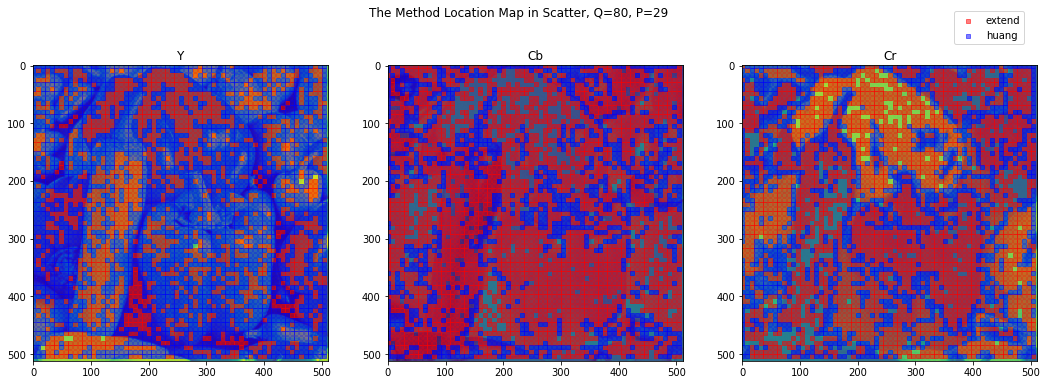

In [29]:
jpeg_rdh.scatter_method()

In [4]:
lm = np.array(jpeg_rdh.locationMap)
maps = [lm[lm[:, 2] == 0], lm[lm[:, 2] == 1], lm[lm[:, 2] == 2]]
n = jpeg_rdh.jpeg.width//jpeg_rdh.jpeg.block_size

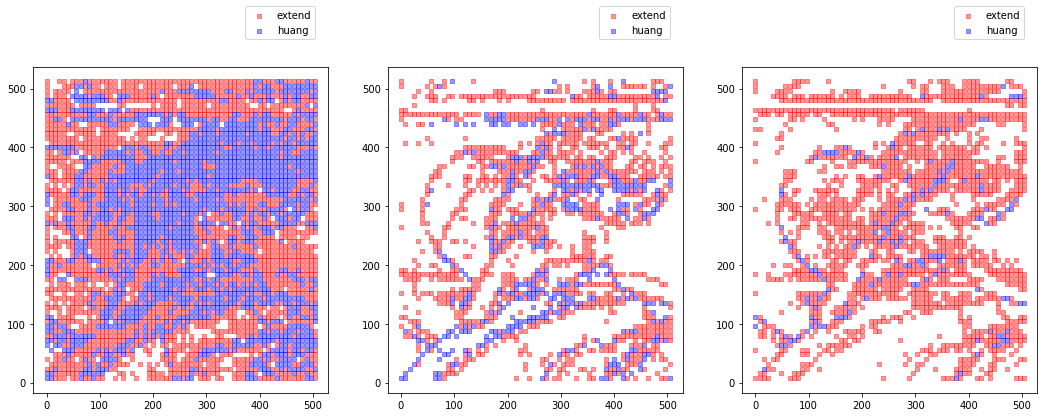

In [108]:
# scale, marker = 10, 'o'
scale, marker, alpha = 9.025, 's', 0.4
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for (index, map) in enumerate(maps):
    extend = map[map[:, 0] == 1][:, 1]
    huang = map[map[:, 0] == -1][:, 1]
    extend_x, extend_y = extend//n, extend%n
    huang_x, huang_y = huang//n, huang%n
    # axs[index].imshow(jpeg_rdh.jpeg.ycbcr[:, :, index])
    axs[index].scatter(extend_x*jpeg_rdh.jpeg.block_size, jpeg_rdh.jpeg.width-extend_y*jpeg_rdh.jpeg.block_size, c="r", marker=marker, s=scale, label="extend", alpha=alpha)
    axs[index].scatter(huang_x*jpeg_rdh.jpeg.block_size, jpeg_rdh.jpeg.width-huang_y*jpeg_rdh.jpeg.block_size, c="b", marker=marker, s=scale, label="huang", alpha=alpha)
    axs[index].legend(bbox_to_anchor=(0.7, 1.2), loc='upper left')

Can embed data of 25491 bits.


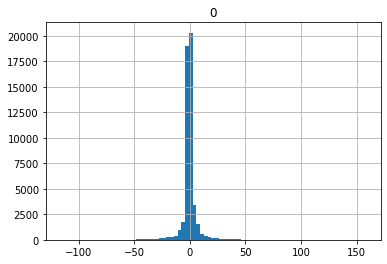

In [5]:
jpeg_rdh.histogram(jpeg_rdh.Blocks)

Can embed data of 12920 bits.


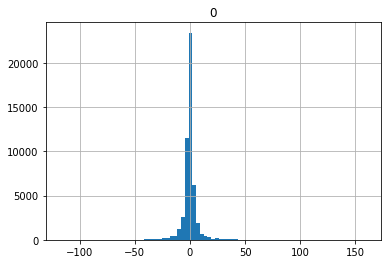

In [6]:
M = np.random.randint(2, size=jpeg_rdh.freeSize())
message = "".join(str(i) for i in M)
embeded_blocks = jpeg_rdh.Embedding(message)
jpeg_rdh.histogram(embeded_blocks)

In [9]:
split = 20

image_set = [
    "../../_Dataset/Basic/Lena.tiff", 
    "../../_Dataset/Basic/boat.tiff", 
    "../../_Dataset/Basic/Baboon.tiff", 
    "../../_Dataset/Basic/Peppers.tiff"
]
quality_List = [50, 60, 70, 80]
isColor = False

for image_index in trange(len(image_set)):
    for quality in quality_List:
        # print("# quality:", quality)
        testImage_path = image_set[image_index]
        jpeg_rdh = JPEG_RDH(testImage_path, quality=quality, T=30)

        jpeg_rdh.prepare(isColor=isColor)
        jpeg_rdh.prepare_ProposeScheme()
        free_size = jpeg_rdh.freeSize()
        # print("## freeSize:", jpeg_rdh.freeSize())

        origin_image_path = jpeg_rdh.generateOriginalImage()
        # origin_image_file = Path(origin_image_path)
        # origin_image_path = "./4th/lena_Q{}.jpg".format(quality)

        # message_len_List = []
        # embedded_imagePath_List = []
        for message_len in trange(free_size//split, free_size, free_size//split):
            M = np.random.randint(2, size=message_len)
            message = "".join(str(i) for i in M)
            file_path = jpeg_rdh.embed_ProposeScheme(message)
            # message_len_List.append(message_len)
            # embedded_imagePath_List.append(file_path)

        # file_size_List = []
        # PSNR_List = []

        # origin_image_path = "./4th/lena_Q{}.jpg".format(quality)
        # origin_image = imageio.imread(origin_image_path)
        # origin_image_file_size = Path(origin_image_path).stat().st_size

    # for file_path in embedded_imagePath_List:
    #     _file_path = "{}.jpg".format(file_path)
    #     image = imageio.imread(_file_path)
    #     file_size_List.append(Path(_file_path).stat().st_size)
    #     PSNR_List.append(psnr(origin_image, image))

    # increased_file_size_List = np.array(file_size_List) - origin_image_file_size

    # print("## Payloads-Increased file sizes")
    # plt.plot(message_len_List, increased_file_size_List)
    # plt.xlabel("Payload (bits)")
    # plt.ylabel("Increased File size (bits)")
    # plt.show()

    # print("## Payloads-Distortion")
    # plt.plot(message_len_List, PSNR_List)
    # plt.xlabel("Payload (bits)")
    # plt.ylabel("PSNR")
    # plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

# quality: 50
## freeSize: 15390


100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


# quality: 60
## freeSize: 17757


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


# quality: 70
## freeSize: 21367


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


# quality: 80
## freeSize: 27074


 25%|██▌       | 1/4 [01:11<03:34, 71.60s/it]

# quality: 50
## freeSize: 20952


100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


# quality: 60
## freeSize: 23048


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


# quality: 70
## freeSize: 26323


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


# quality: 80
## freeSize: 32288


 50%|█████     | 2/4 [02:41<02:44, 82.18s/it]

# quality: 50
## freeSize: 36068


100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


# quality: 60
## freeSize: 39375


100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


# quality: 70
## freeSize: 43548


100%|██████████| 20/20 [00:37<00:00,  1.86s/it]


# quality: 80
## freeSize: 51018


 75%|███████▌  | 3/4 [05:06<01:50, 110.79s/it]

# quality: 50
## freeSize: 15989


100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


# quality: 60
## freeSize: 18847


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


# quality: 70
## freeSize: 23292


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


# quality: 80
## freeSize: 29910


100%|██████████| 4/4 [06:19<00:00, 94.82s/it] 


C:\Users\BREND\AppData\Local\Temp\ipykernel_920\2361228165.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  origin_image = imageio.imread(origin_image_path)
C:\Users\BREND\AppData\Local\Temp\ipykernel_920\2361228165.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(_file_path)


## Payloads-Increased file sizes


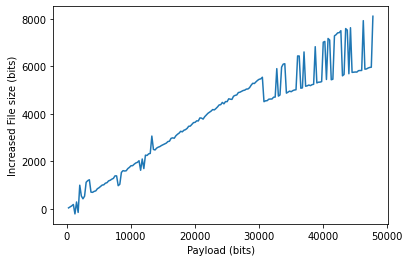

## Payloads-Distortion


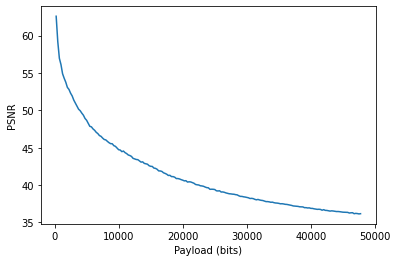

In [37]:
file_size_List = []
PSNR_List = []

origin_image_path = "./lena_color_Q{}.jpg".format(quality)
origin_image = imageio.imread(origin_image_path)
origin_image_file_size = Path(origin_image_path).stat().st_size
for file_path in embedded_imagePath_List:
    _file_path = "{}.jpg".format(file_path)
    image = imageio.imread(_file_path)
    file_size_List.append(Path(_file_path).stat().st_size)
    PSNR_List.append(psnr(origin_image, image))
increased_file_size_List = np.array(file_size_List) - origin_image_file_size
print("## Payloads-Increased file sizes")
plt.plot(message_len_List, increased_file_size_List)
plt.xlabel("Payload (bits)")
plt.ylabel("Increased File size (bits)")
plt.show()
print("## Payloads-Distortion")
plt.plot(message_len_List, PSNR_List)
plt.xlabel("Payload (bits)")
plt.ylabel("PSNR")
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]C:\Users\BREND\AppData\Local\Temp\ipykernel_19544\2702216488.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  origin_image = imageio.imread(origin_image_path)
C:\Users\BREND\AppData\Local\Temp\ipykernel_19544\2702216488.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file_path)
100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


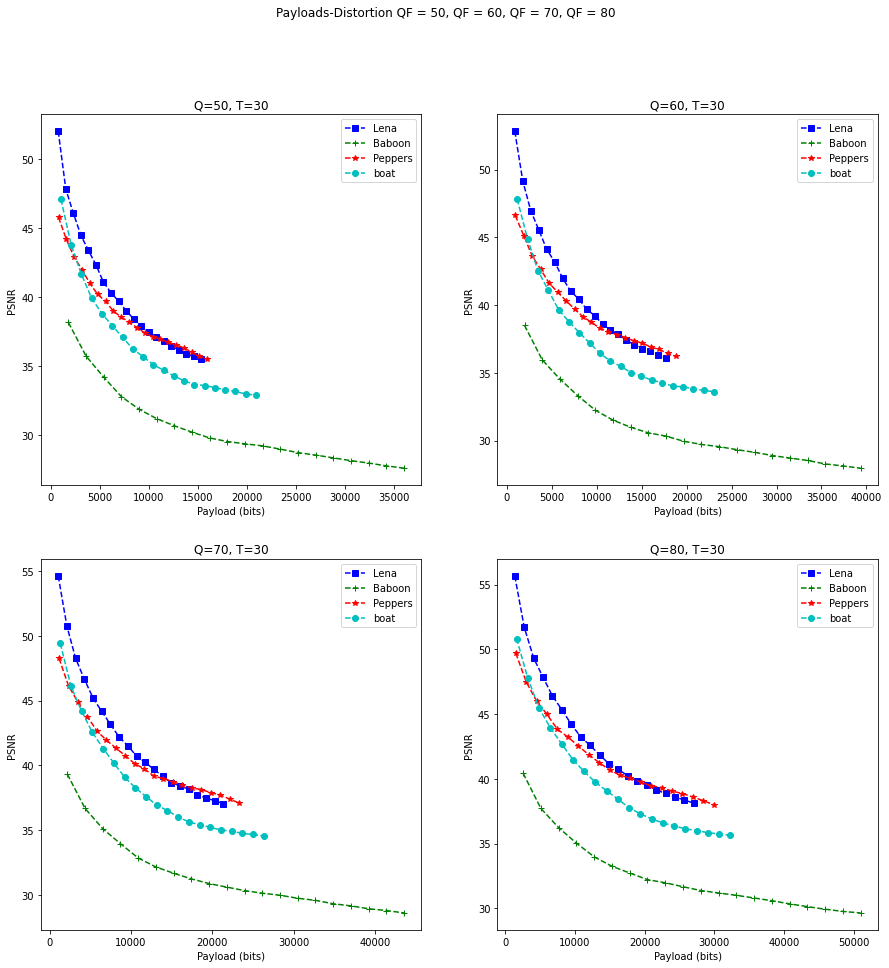

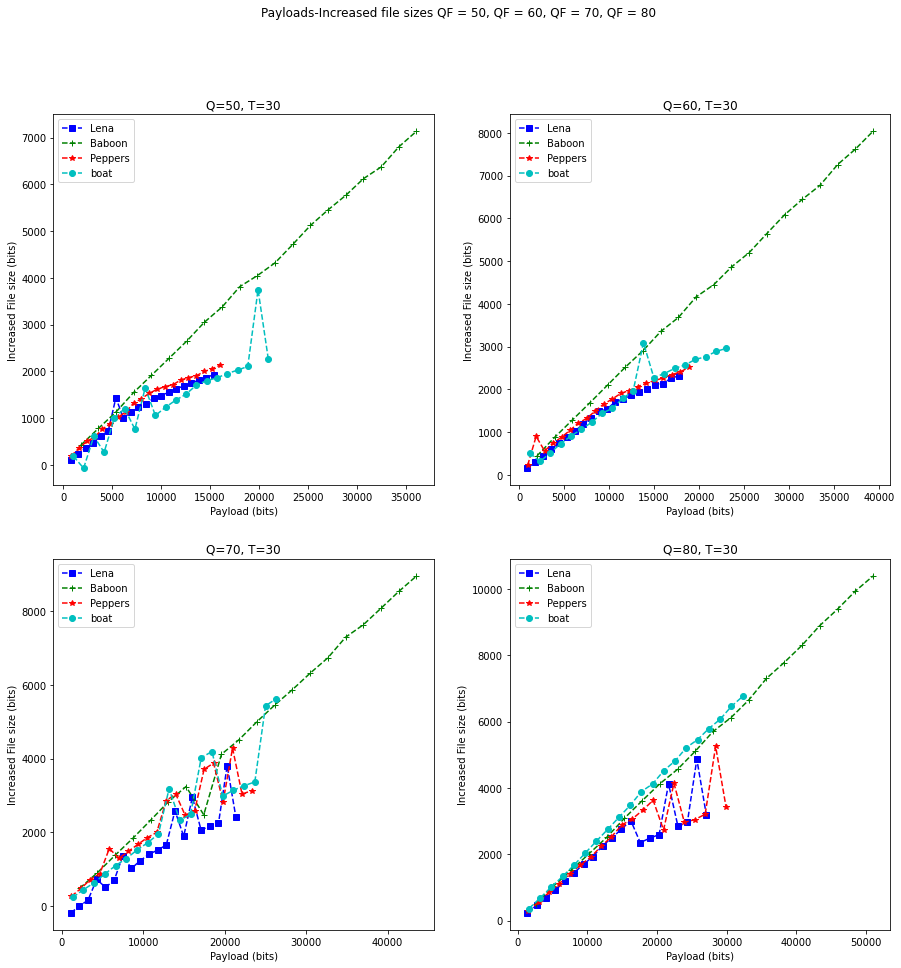

In [12]:
fig12, axs12 = plt.subplots(2, 2, figsize=(15, 15))
fig13, axs13 = plt.subplots(2, 2, figsize=(15, 15))

# image_set = ["lena_color", "boat", "Baboon", "Peppers"]
image_set = ["Lena", "Baboon", "Peppers", "boat"]
image_set_color = ["bs--", "g+--", "r*--", "co--"]
# image_set_color = ["b-", "g-", "r-", "c-"]

dir = "./4th"

quality_List = [50, 60, 70, 80]
for image_index in trange(len(image_set)):
    # print("# image:", image_set[image_index])
    for index in range(len(quality_List)):
        # print("## quality:", quality_List[index])

        message_len_List = []
        file_size_List = []
        PSNR_List = []

        origin_image_path = "{}/{}_Q{}.jpg".format(dir, image_set[image_index], quality_List[index])
        # origin_image_path = "../../_Dataset/Lenna/lena_color.gif"
        origin_image = imageio.imread(origin_image_path)
        origin_image_file_size = Path(origin_image_path).stat().st_size

        file_paths = Path("{}/".format(dir)).glob("{}_DHS_Propose_Q{}*.jpg".format(image_set[image_index], quality_List[index]))
        # print("number of file:", len(list(file_paths)))

        for file_path in file_paths:
            message_len_List.append(int(str(file_path).split(".")[0].split("_P")[-1]))
            # print("### P:", message_len_List[-1])
            
            image = imageio.imread(file_path)
            file_size_List.append(Path(file_path).stat().st_size)
            PSNR_List.append(psnr(origin_image, image))

        analize = np.zeros((len(message_len_List), 3))
        # print(analize.shape)
        analize[:, 0] = message_len_List
        analize[:, 1] = file_size_List
        analize[:, 2] = PSNR_List

        analize = sorted(analize, key=lambda x: x[0])
        # print(analize[0], analize[-1])

        message_len_List = list(zip(*np.array(analize)))[0]
        file_size_List = list(zip(*np.array(analize)))[1]
        PSNR_List = list(zip(*np.array(analize)))[2]

        increased_file_size_List = np.array(file_size_List) - origin_image_file_size

        # print("### Payloads-Increased file sizes")
        axs13[index//2, index%2].plot(message_len_List, increased_file_size_List, image_set_color[image_index], label=image_set[image_index])
        axs13[index//2, index%2].set_title("Q={}, T={}".format(quality_List[index], 30))
        axs13[index//2, index%2].set_xlabel("Payload (bits)")
        axs13[index//2, index%2].set_ylabel("Increased File size (bits)")
        axs13[index//2, index%2].legend()

        # print("### Payloads-Distortion")
        axs12[index//2, index%2].plot(message_len_List, PSNR_List, image_set_color[image_index], label=image_set[image_index])
        axs12[index//2, index%2].set_title("Q={}, T={}".format(quality_List[index], 30))
        axs12[index//2, index%2].set_xlabel("Payload (bits)")
        axs12[index//2, index%2].set_ylabel("PSNR")
        axs12[index//2, index%2].legend()

fig12.suptitle("Payloads-Distortion QF = 50, QF = 60, QF = 70, QF = 80")
fig13.suptitle("Payloads-Increased file sizes QF = 50, QF = 60, QF = 70, QF = 80")

plt.show()

更佳的壓縮法
- HuffmanTable